In [14]:
import pandas as pd
import matplotlib as plt
import numpy as np
from fuzzywuzzy import process
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import shapiro


In [15]:
df = pd.read_csv("PLACES_Local_Data_for_Better_Health_County_Data_2022_release_20250320.csv")

df = df[df["Data_Value_Type"].str.contains("Crude", na=False)]
df = df[df['TotalPopulation'] > 100000]

# Rename the city column
df = df.rename(columns={"LocationName": "city"})


# Drop unnecessary columns
df = df.drop(['StateAbbr', 'StateDesc', 'DataSource', 'Category', 'LocationID', 'CategoryID', 'DataValueTypeID', 'Geolocation', 'Low_Confidence_Limit', 'High_Confidence_Limit', 'Data_Value_Footnote_Symbol', 'MeasureId', 'Data_Value_Footnote' ], axis=1)
# First, let's identify the unique cities and measures
unique_cities = df['city'].unique()
unique_measures = df['Short_Question_Text'].unique()

print(f"Number of unique cities: {len(unique_cities)}")
print(f"Number of unique measures: {len(unique_measures)}")



# Create a pivot table with cities as index and measures as columns
new_df = df.pivot_table(
    index='city',
    columns='Measure',
    values='Data_Value',
    aggfunc='mean'  # Use mean if there are duplicate entries
)

population_df = df.groupby('city')['TotalPopulation'].first().reset_index()

# Reset the index to make 'city' a column again
new_df = new_df.reset_index()

new_df = new_df.drop(['Current lack of health insurance among adults aged 18-64 years',
'Cervical cancer screening among adult women aged 21-65 years',
'Visits to dentist or dental clinic among adults aged >=18 years',
 'Visits to doctor for routine checkup within the past year among adults aged >=18 years',
 'Mammography use among women aged 50-74 years',
 'Cholesterol screening among adults aged >=18 years',
 'Older adult men aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening',
 'Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years',
 'Older adult women aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening, and Mammogram past 2 years',
], axis=1)

# All diseases
# list(df['Measure'].unique())


df.head()



Number of unique cities: 494
Number of unique measures: 30


,Year,city,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,TotalPopulation,Short_Question_Text
0,2020,NaN,Current lack of health insurance among adults ...,%,Crude prevalence,15.3,331449281,Health Insurance
5,2020,Anchorage,Depression among adults aged >=18 years,%,Crude prevalence,16.5,287095,Depression
17,2020,Navajo,Arthritis among adults aged >=18 years,%,Crude prevalence,30.4,112112,Arthritis
18,2019,Pinal,High blood pressure among adults aged >=18 years,%,Crude prevalence,31.0,480828,High Blood Pressure
27,2020,El Dorado,All teeth lost among adults aged >=65 years,%,Crude prevalence,7.8,192925,All Teeth Lost


In [ ]:
airdf = pd.read_excel("who_ambient_air_quality_database_version_2024_(v6.1).xlsx", sheet_name="Update 2024 (V6.1)")


# Filter by US
airdf = airdf[airdf["country_name"] == "United States of America"]

# Drop unnnecessary columns
airdf = airdf.drop(['country_name', 'version','reference','web_link', 'population_source','who_ms', 'type_of_stations', 'population', 'latitude', 'longitude', 'iso3', 'who_region', 'pm25_tempcov', 'pm10_tempcov','no2_tempcov'], axis=1)

# Remove state from city names
airdf['city'] = airdf['city'].str.split(' ').str[0]
airdf['city'] = airdf['city'].str.split('-').str[0]
# Leave only year 2020
airdf = airdf[airdf['year'] == 2019.0]


In [ ]:
# Merge the dataframes to get the common cities that are in both datasets
merged_df = pd.merge(new_df, airdf, on='city', how='inner')
merged_df = pd.merge(merged_df, population_df, on='city', how='left')
merged_df = merged_df.drop_duplicates(subset='city', keep='first')

# Optional: print some information about the merged DataFrame
print(merged_df.shape)
print("Columns with non-null PM10 concentrations:", merged_df['pm10_concentration'].notna().sum())
print("Columns with non-null PM2.5 concentrations:", merged_df['pm25_concentration'].notna().sum())
print("Columns with non-null NO2 concentrations:", merged_df['no2_concentration'].notna().sum())

(98, 27)
Columns with non-null PM10 concentrations: 56
Columns with non-null PM2.5 concentrations: 96
Columns with non-null NO2 concentrations: 42


Merged dataframe columns: ['city', 'All teeth lost among adults aged >=65 years', 'Arthritis among adults aged >=18 years', 'Binge drinking among adults aged >=18 years', 'Cancer (excluding skin cancer) among adults aged >=18 years', 'Chronic kidney disease among adults aged >=18 years', 'Chronic obstructive pulmonary disease among adults aged >=18 years', 'Coronary heart disease among adults aged >=18 years', 'Current asthma among adults aged >=18 years', 'Current smoking among adults aged >=18 years', 'Depression among adults aged >=18 years', 'Diagnosed diabetes among adults aged >=18 years', 'Fair or poor self-rated health status among adults aged >=18 years', 'High blood pressure among adults aged >=18 years', 'High cholesterol among adults aged >=18 years who have been screened in the past 5 years', 'Mental health not good for >=14 days among adults aged >=18 years', 'No leisure-time physical activity among adults aged >=18 years', 'Obesity among adults aged >=18 years', 'Physica

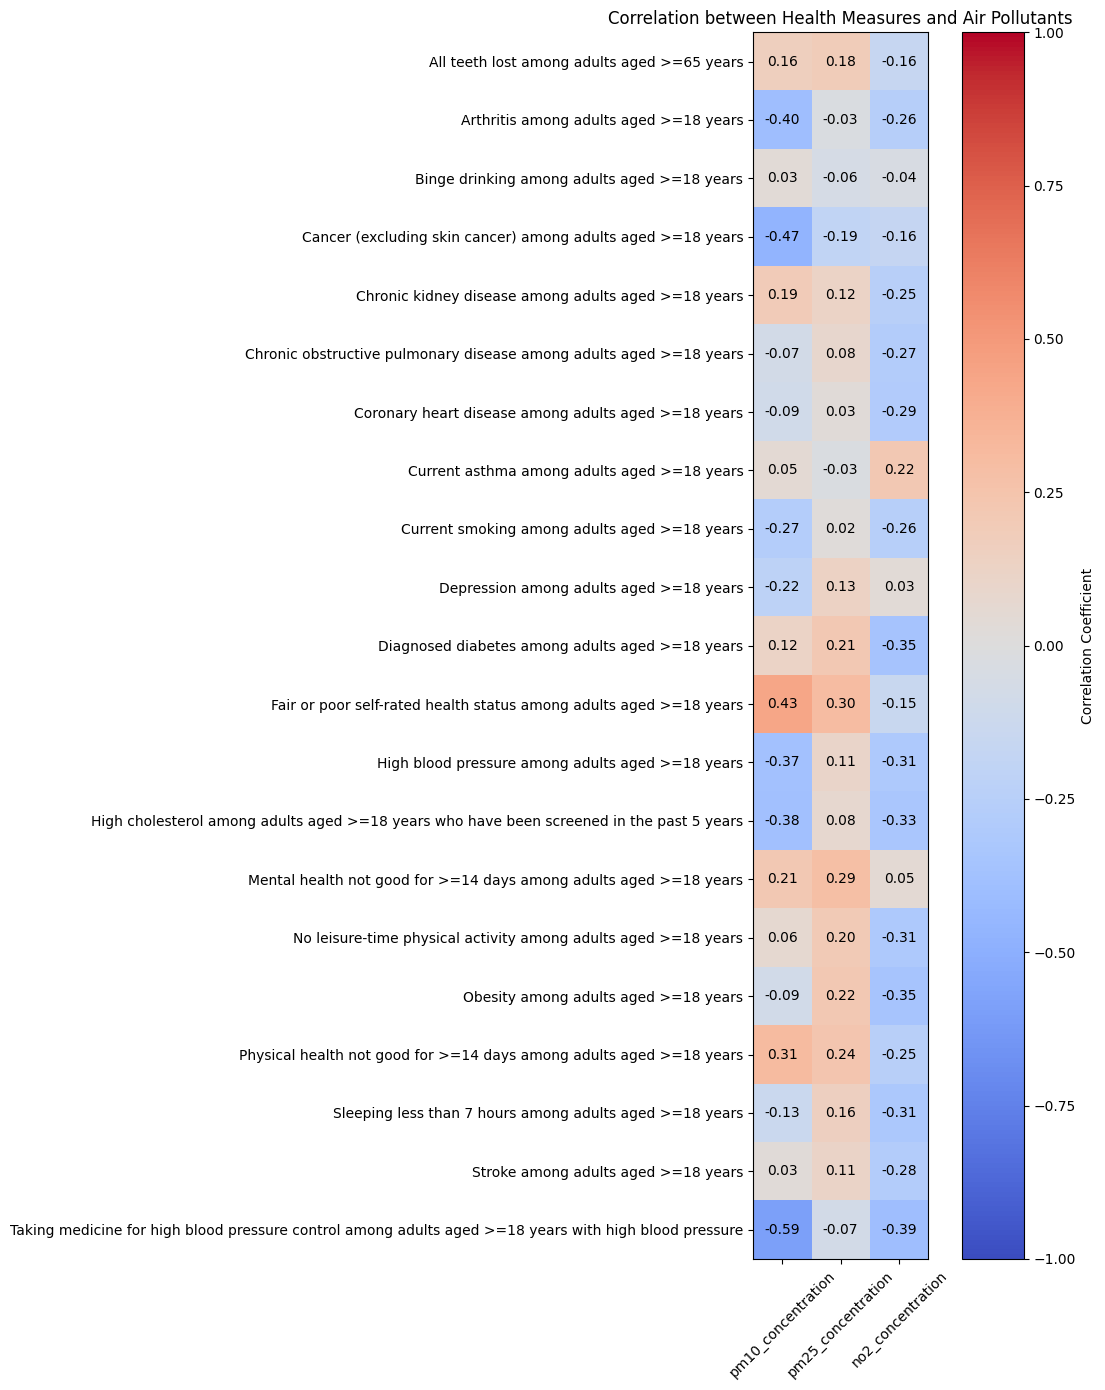

In [19]:
# Print all column names to identify the correct ones
print("Merged dataframe columns:", merged_df.columns.tolist())

# Update these with the ACTUAL column names from your print output
pollutants = ['pm10_concentration', 'pm25_concentration', 'no2_concentration']  # Use the correct names

# Get disease columns
disease_columns = [col for col in new_df.columns if col != 'city']

# Create a correlation matrix between pollutants and diseases
correlation_matrix = merged_df[pollutants + disease_columns].corr()

# Extract and transpose the correlation matrix - diseases as rows and pollutants as columns
disease_pollutant_corr = correlation_matrix.loc[disease_columns, pollutants]

# Display the correlation matrix
print("Correlation between health measures and air pollutants:")
disease_pollutant_corr

# Visualize the correlation matrix as a heatmap using matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 14))  # Adjusted for more rows than columns
im = plt.imshow(disease_pollutant_corr, cmap='coolwarm', vmin=-1, vmax=1)

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Correlation Coefficient')

# Add labels and title
plt.title('Correlation between Health Measures and Air Pollutants')
plt.xticks(np.arange(len(pollutants)), pollutants, rotation=45)
plt.yticks(np.arange(len(disease_columns)), disease_columns)

# Add correlation values as text annotations
for i in range(len(disease_columns)):
    for j in range(len(pollutants)):
        text = plt.text(j, i, f'{disease_pollutant_corr.iloc[i, j]:.2f}', ha="center", va="center", color="black")

plt.tight_layout()
plt.savefig('corr.png')
plt.show()

In [20]:
#This puts merged df into an array to use Scipy

array = merged_df.to_numpy()

print(array.shape)

array[:,6]


(98, 27)


array([5.9, 4.0, 8.850000000000001, 4.6, 5.2, 7.2, 5.8, 9.3, 7.2, 8.2,
       4.4, 7.0, 8.7, 5.7, 7.7, 6.6, 6.0, 11.9, 8.025, 6.5, 5.6, 5.8, 4.3,
       5.8, 5.0, 6.2, 5.5, 7.0, 8.6, 7.65, 7.666666666666667, 8.4, 6.7,
       7.85, 6.6, 7.6, 5.6, 7.4, 6.0, 7.75, 6.2, 7.775, 9.2, 6.9, 6.5,
       6.1, 6.9, 8.075, 6.7, 6.3, 8.2, 7.3, 5.5, 7.1, 8.2, 7.8, 7.25, 6.8,
       9.1, 6.1, 5.4, 8.8, 7.15, 6.583333333333333, 9.7, 6.6, 7.0, 7.0,
       8.5, 7.2, 6.4, 7.1, 6.3, 5.9, 7.0, 6.9, 7.0, 6.1, 6.7, 6.2, 4.5,
       4.0, 3.9, 5.2, 4.4, 7.6, 6.8, 9.1, 7.8, 7.2, 5.6,
       6.588888888888889, 7.5, 7.5, 5.9, 7.5, 7.333333333333333, 7.6],
      dtype=object)

In [21]:
whole_population = np.sum(array[:,26])
print(whole_population)
wheighting_array = array[:,26]/whole_population
wheighting_array


56128438


array([0.005409984863644344, 0.002827906951552794, 0.006809150826538234,
       0.005114965073498037, 0.010382918548347986, 0.004684701897458825,
       0.014716550636951629, 0.003052320821755275, 0.0034858621934214526,
       0.002896481815510348, 0.005828970334075571, 0.01009764426367967,
       0.002655320641561413, 0.007956679642501364, 0.003790306795995285,
       0.004223402760646929, 0.007446866773666497, 0.0034690258082720918,
       0.002124876519813361, 0.005114448401361178, 0.002857321630792576,
       0.04696172018897087, 0.013104551386233124, 0.00642722321971618,
       0.005831375531954052, 0.007834335243749345, 0.0018753416939911993,
       0.00343720593115383, 0.0036730222209283643, 0.016341823016703227,
       0.002063499433210666, 0.0024513064126245594, 0.017832635926907498,
       0.003030941285057674, 0.009486919981632128, 0.003680683221578338,
       0.08441804491334678, 0.0037200572016630857, 0.01584269991621716,
       0.00189885918435856, 0.005177571483460844, 0

In [22]:
#This is a test correlation for one disease 

X1=array[:,14]*wheighting_array
Y=array[:,23]
print(array[:,14])
print(X1)

x = X1.astype(float)
y = Y.astype(float)

mask = ~np.isnan(y)& ~np.isnan(x)

Y_filtered=y[mask]
X1_filtered=x[mask]

res = stats.pearsonr(X1_filtered, Y_filtered)

res

[30.9 29.5 30.950000000000003 29.4 32.2 nan 33.1 35.25 38.7 37.0 27.6 30.1
 41.7 nan 29.9 32.0 34.1 41.2 33.35 31.3 30.6 30.8 25.8 31.52 29.1 31.8
 30.6 32.9 32.4 33.849999999999994 33.6 34.7 29.0 32.1 33.7 33.7 34.1 36.9
 32.9 34.55 31.4 34.95 33.2 33.9 32.1 27.9 33.8 32.6 33.0 28.1 32.6 35.4
 28.6 31.2 34.2 30.0 34.275000000000006 28.7 33.1 32.3 27.5 36.5 31.5
 32.53333333333333 36.3 32.6 31.8 32.4 33.0 35.5 33.5 30.8 31.7 32.4 29.8
 31.5 31.1 30.8 32.8 28.5 27.5 28.0 26.9 30.700000000000003 nan 37.5 31.4
 37.9 34.0 31.9 31.0 32.211111111111116 33.2 29.4 30.8 30.4
 33.266666666666666 34.2]
[0.16716853228661022 0.08342325507080742 0.21074321808135835
 0.15037997316084226 0.3343299772568052 nan 0.48711782608309895
 0.10759430896687344 0.13490286688541023 0.10716982717388288
 0.16087958122048576 0.3039390923367581 0.11072687075311093 nan
 0.11333017320025902 0.13514888834070174 0.25393815698202754
 0.1429238633008102 0.0708646319357756 0.16008223496260487
 0.08743404190225283 1.44642098

PearsonRResult(statistic=np.float64(0.08793104524036066), pvalue=np.float64(0.5232301808437783))

Now we want to find out whether the data is normally distributed so that we know how to compute the correlation

In [23]:

column_data = np.array(array[:,6], dtype=float)  # Convert to float

# Perform KS test against normal distribution
ks_statistic, p_value = stats.kstest(column_data, 'norm')
# Normalise for the KS test
column_data = (column_data - np.mean(column_data)) / np.std(column_data)

print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Data is NOT normally distributed.")
else:
    print("Fail to reject the null hypothesis: Data is likely normally distributed.")


#Here we note that the result is extremely suspicious, therfore we perform different tests(probably more suited for large datasets and normality testing)

KS Statistic: 0.9999519036559824
P-value: 0.0
Reject the null hypothesis: Data is NOT normally distributed.


We find this result extremely suspicious hence we use different test satatistics for checking normality

In [24]:
#Shapiro-Wilk normality test
stat, p_value = shapiro(column_data)
print(f"Shapiro-Wilk p-value: {p_value}")

# D'Agostino and Pearson's test
from scipy.stats import normaltest
stat, p_value = normaltest(column_data)
print(f"D'Agostino-Pearson p-value: {p_value}")

Shapiro-Wilk p-value: 0.13842653788211473
D'Agostino-Pearson p-value: 0.06411960972532725


Here we find that the data is indeed normally distributed and as KS test is very prone to overinterpretation of outlying values and not suited for large datasets, we trust Shapiro-Wilk test and decide to go for pearson correlation test without permutation

In [25]:
air_pollution_parameter = [23,24,25]
disease_range_start = 1
disease_range_end = 21

#permutation_model=stats.PermutationMethod(n_resamples=99999, batch=None, random_state=None, rng=None)

# Ensure Corr array matches the range
Corr_p_values = np.zeros((disease_range_end - disease_range_start + 1,len(air_pollution_parameter)))
Corr_coef = np.zeros((disease_range_end - disease_range_start + 1,len(air_pollution_parameter)))

#This computes p-values of pearson correlation test statistic between diseases and different air pollutants and puts it into a 21x3 array
for j in range(0,len(air_pollution_parameter)):
    y = array[:, air_pollution_parameter[j]]

    for i in range(disease_range_start, disease_range_end + 1):
        try:
            # Extract disease column
            a = array[:, i]#*wheighting_array
            
            # Convert to float as datasets are super messy
            a_float = a.astype(float)
            y_float = y.astype(float)
            
            # Create mask for non-NaN values in BOTH columns
            mask =  ~np.isnan(y_float) & ~np.isnan(a_float) 
            
            # Filter both arrays
            y_filtered = y_float[mask]
            a_filtered = a_float[mask]
            
            # Compute Pearson correlation
            res = stats.pearsonr(a_filtered, y_filtered)
            
            Corr_p_values[i - disease_range_start,j] = res.pvalue
            Corr_coef[i - disease_range_start,j]=res.correlation
            
        except Exception as e:
            print(f"Error processing column {i}: {e}")

print(Corr_coef)
Corr_p_values

[[ 0.16160786  0.18466238 -0.1575619 ]
 [-0.39747918 -0.0292985  -0.25980318]
 [ 0.0346297  -0.06117417 -0.04299102]
 [-0.46757774 -0.18915101 -0.16450139]
 [ 0.19100464  0.11792143 -0.24956865]
 [-0.07160979  0.08044706 -0.27479273]
 [-0.09274786  0.02623669 -0.28622822]
 [ 0.0536988  -0.03104431  0.21532438]
 [-0.26903314  0.0205154  -0.25688496]
 [-0.21581799  0.13228469  0.03392416]
 [ 0.11972552  0.21151499 -0.3548387 ]
 [ 0.43083301  0.30106853 -0.14776402]
 [-0.3678865   0.10526089 -0.31135913]
 [-0.37576402  0.07619148 -0.32937832]
 [ 0.2142922   0.28531455  0.05406073]
 [ 0.06367033  0.2025784  -0.30563117]
 [-0.08582706  0.21539488 -0.34519754]
 [ 0.30608348  0.23971011 -0.24854365]
 [-0.12501896  0.15587973 -0.31270705]
 [ 0.02949266  0.10990019 -0.27638694]
 [-0.59242907 -0.07068068 -0.39218947]]


array([[2.34075110e-01, 7.16812622e-02, 3.18985747e-01],
       [2.41796418e-03, 7.76896344e-01, 9.65981846e-02],
       [7.99977608e-01, 5.53793464e-01, 7.86906077e-01],
       [2.79675152e-04, 6.49334799e-02, 2.97861282e-01],
       [1.58501245e-01, 2.52519230e-01, 1.10954796e-01],
       [5.99954241e-01, 4.35887954e-01, 7.82050580e-02],
       [4.96583621e-01, 7.99694669e-01, 6.61141813e-02],
       [6.94271105e-01, 7.63979756e-01, 1.70850913e-01],
       [4.49646530e-02, 8.42734615e-01, 1.00537485e-01],
       [1.10154892e-01, 1.98863591e-01, 8.31108502e-01],
       [3.79453539e-01, 3.85709074e-02, 2.11208384e-02],
       [9.17481752e-04, 2.87591511e-03, 3.50375684e-01],
       [5.72226271e-03, 3.15299948e-01, 4.75263037e-02],
       [4.69650165e-03, 4.67910701e-01, 3.54740158e-02],
       [1.12754687e-01, 4.83690037e-03, 7.33834534e-01],
       [6.41077871e-01, 4.77677546e-02, 4.90308953e-02],
       [5.29383723e-01, 3.50663879e-02, 2.51596589e-02],
       [2.17776416e-02, 1.86572

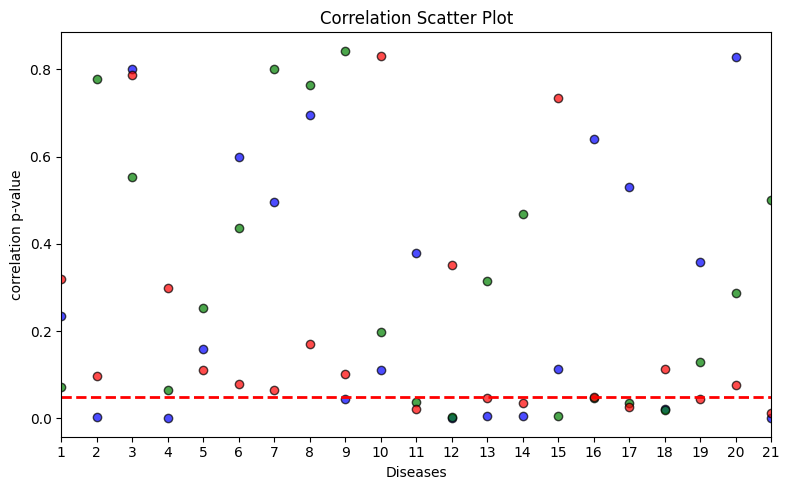

Length of Corr: 21
Length of features: 21


In [26]:
#This creates a scatter plot of diseases and thier p-values

features = np.arange(1, len(Corr_p_values) + 1)



plt.figure(figsize=(8,5))
plt.scatter(features, Corr_p_values[:,0], color='blue', edgecolors='black', alpha=0.7)
plt.scatter(features, Corr_p_values[:,1], color='green', edgecolors='black', alpha=0.7)
plt.scatter(features, Corr_p_values[:,2], color='red', edgecolors='black', alpha=0.7)
# Red line at y=0.05
plt.axhline(y=0.05, color='red', linestyle='--', linewidth=2)

plt.xlim(1, len(Corr_p_values))

plt.xticks(features)

plt.xlabel('Diseases')
plt.ylabel('correlation p-value')
plt.title('Correlation Scatter Plot')

plt.tight_layout()
plt.show()

# Verify lengths
print("Length of Corr:", len(Corr_p_values))
print("Length of features:", len(features))

(21, 3)
(21, 3)
[[           nan            nan            nan]
 [2.41796418e-03            nan            nan]
 [           nan            nan            nan]
 [2.79675152e-04            nan            nan]
 [           nan            nan            nan]
 [           nan            nan            nan]
 [           nan            nan            nan]
 [           nan            nan            nan]
 [4.49646530e-02            nan            nan]
 [           nan            nan            nan]
 [           nan 3.85709074e-02 2.11208384e-02]
 [9.17481752e-04 2.87591511e-03            nan]
 [5.72226271e-03            nan 4.75263037e-02]
 [4.69650165e-03            nan 3.54740158e-02]
 [           nan 4.83690037e-03            nan]
 [           nan 4.77677546e-02 4.90308953e-02]
 [           nan 3.50663879e-02 2.51596589e-02]
 [2.17776416e-02 1.86572419e-02            nan]
 [           nan            nan 4.37692032e-02]
 [           nan            nan            nan]
 [1.89024875e-06        

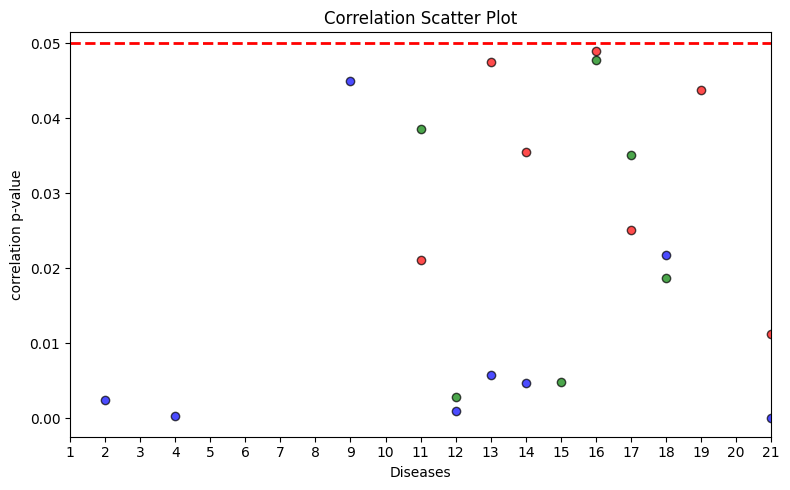

Length of Corr_significant: 21
Length of features: 21


In [27]:
#This filters the Corr matrix so that only statistically significant values (p<=0.05) remain
print(Corr_p_values.shape)

Corr_significat_p=Corr_p_values.copy() #if I dont use copy(), Corr also changes when I change Corr_significant
Corr_significat_p[Corr_significat_p > 0.05] = np.nan
print(Corr_significat_p.shape)
print(Corr_significat_p)

#This creates a scatter plot with statistically significant values

features = np.arange(1, len(Corr_significat_p) + 1)

plt.figure(figsize=(8,5))
plt.scatter(features, Corr_significat_p[:,0], color='blue', edgecolors='black', alpha=0.7)
plt.scatter(features, Corr_significat_p[:,1], color='green', edgecolors='black', alpha=0.7)
plt.scatter(features, Corr_significat_p[:,2], color='red', edgecolors='black', alpha=0.7)
# Red line at y=0.05
plt.axhline(y=0.05, color='red', linestyle='--', linewidth=2)

plt.xlim(1, len(Corr_p_values))

plt.xticks(features)

plt.xlabel('Diseases')
plt.ylabel('correlation p-value')
plt.title('Correlation Scatter Plot')

plt.tight_layout()
plt.show()

# Verify lengths
print("Length of Corr_significant:", len(Corr_significat_p))
print("Length of features:", len(features))

Now, as I want to present the data as a table I switch to dataframes as it makes it easier

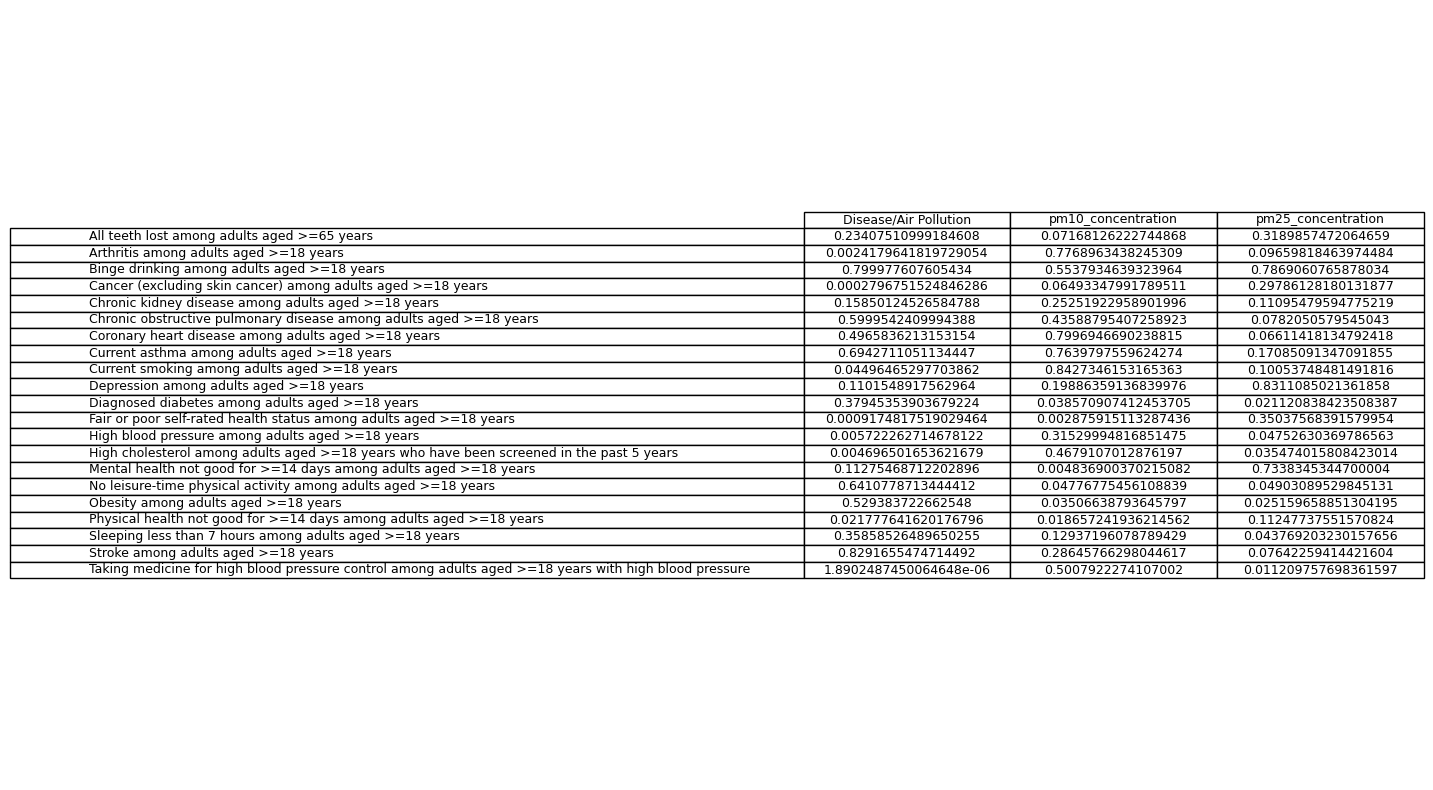

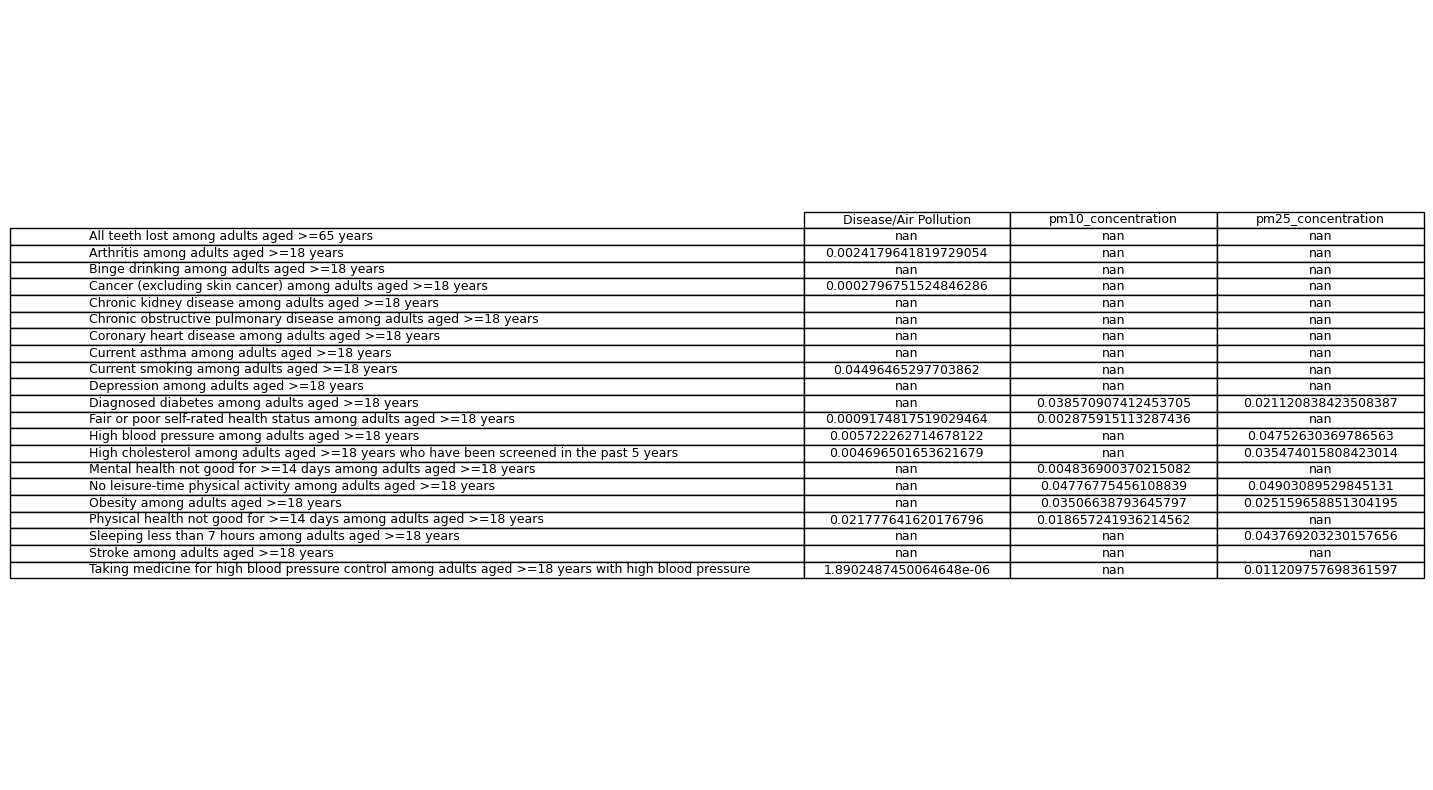

In [28]:
correlation_p_value_df= pd.DataFrame(Corr_p_values, index=disease_columns, columns=pollutants)

significant_correlation_p_value_df = correlation_p_value_df.where(correlation_p_value_df <= 0.05, np.nan)

fig, ax = plt.subplots(figsize=(8, 10))
ax.axis('tight')
ax.axis('off')

ax.table(
    cellText=correlation_p_value_df.values, 
    colLabels=["Disease/Air Pollution"] + pollutants, 
    rowLabels=correlation_p_value_df.index, 
    cellLoc='center', 
    loc='center'
)
plt.show()

fig, ax = plt.subplots(figsize=(8, 10))
ax.axis('tight')
ax.axis('off')

ax.table(
    cellText=significant_correlation_p_value_df.values, 
    colLabels=["Disease/Air Pollution"] + pollutants, 
    rowLabels=significant_correlation_p_value_df.index, 
    cellLoc='center', 
    loc='center'
)
plt.show()


Now I want to filter the correlation coefficient data so that it leaves only the statistically signifficant coefficients

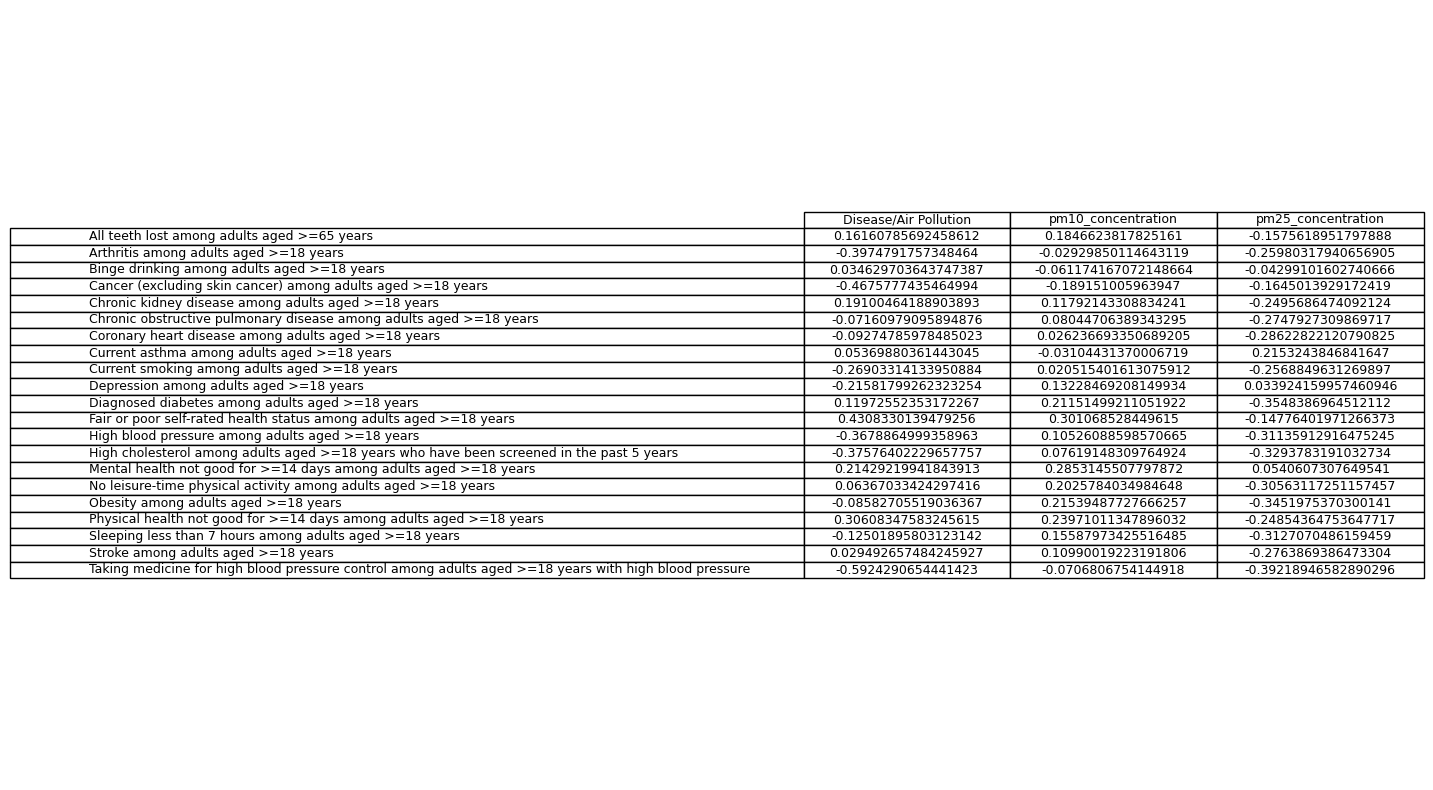

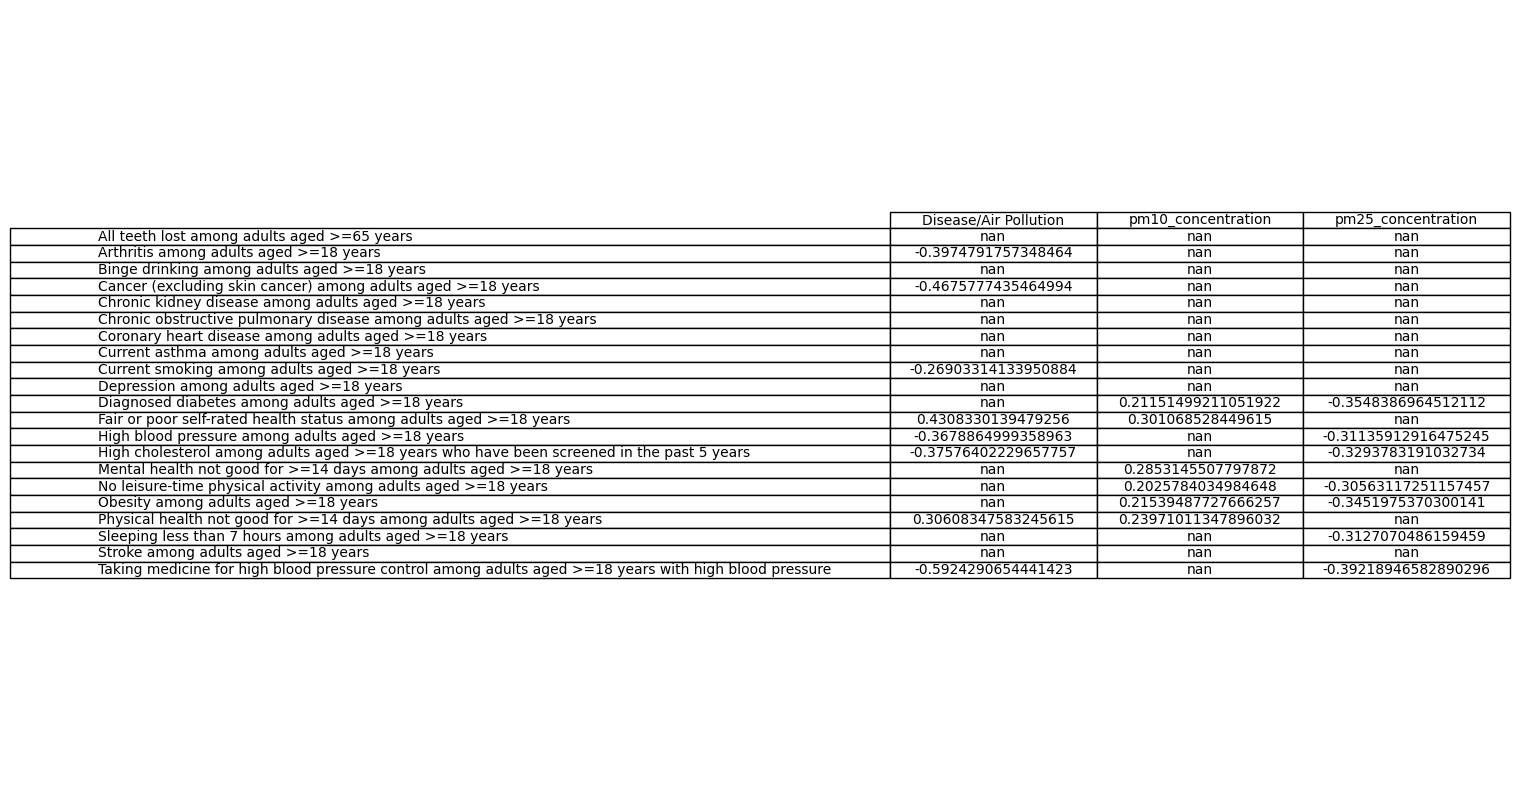

In [29]:
sign_Corr_coef = np.where(Corr_p_values < 0.05, Corr_coef, np.nan)
sign_Corr_coef

correlation_coef_df= pd.DataFrame(Corr_coef, index=disease_columns, columns=pollutants)
sign_correlation_coef_df= pd.DataFrame(sign_Corr_coef, index=disease_columns, columns=pollutants)

fig, ax = plt.subplots(figsize=(8, 10))
ax.axis('tight')
ax.axis('off')

ax.table(
    cellText=correlation_coef_df.values, 
    colLabels=["Disease/Air Pollution"] + pollutants, 
    rowLabels=correlation_coef_df.index, 
    cellLoc='center', 
    loc='center'
)
plt.show()

fig, ax = plt.subplots(figsize=(8, 10))
ax.axis('tight')
ax.axis('off')

ax.table(
    cellText=sign_correlation_coef_df.values, 
    colLabels=["Disease/Air Pollution"] + pollutants, 
    rowLabels=sign_correlation_coef_df.index, 
    cellLoc='center', 
    loc='center'
)
plt.show()

